In [6]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt

#This function threshold_local will help us obtain the “black and white” feel to our scanned image.
from skimage.filters import threshold_local

STEP 1: Edge Detection


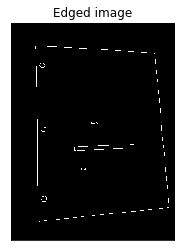

In [7]:
##-----------------------Canny Edge Detection------------------------##

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("images/page.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
 
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
 
# show the original image and the edge detected image
print("STEP 1: Edge Detection")

# plt.subplot(1, 2, 1)
# plt.imshow(image, cmap='gray')
# plt.title('Image')
# plt.xticks([]), plt.yticks([])

# plt.subplot(1, 2, 2) # row, col, current_col
# plt.imshow(edged, cmap='gray')
# plt.title("Edged image")
# plt.xticks([]), plt.yticks([])

plt.imshow(edged, cmap='gray')
plt.title("Edged image")
plt.xticks([]), plt.yticks([])
plt.show()

plt.show()

approx
[[[ 57  54]]

 [[ 61 456]]

 [[360 425]]

 [[329  72]]]
STEP 2: Find contours of paper


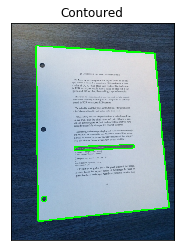

In [14]:
##-----------------------Contouring------------------------##


# # find the contours in the edged image, keeping only the
# # largest ones, and initialize the screen contour
# cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]
# cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

 
# # show the contour (outline) of the piece of paper
# print("STEP 2: Find contours of paper")
# cnt = cnts[1]
# #draw individual contours
# # cv2.drawContours(image, cnts, 3, (0,255,0), 3)
# # cv2.drawContours(image, cnts, 1, (0,255,0), 3)

# #draw all the contours
# #cv2.drawContours(image, cnts, -1, (0,255,0), 3)

# #draw 0th contour
# cv2.drawContours(image, cnts, 0, (0,255,0), 3)


# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    print("approx")
    print(approx)

    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break
 
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

plt.imshow(image)
plt.title("Contoured")
plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
#------------------------ORDER POINTS, for top-left, top-right, etc. to handle if not---------------------------

#four-point-perspective-transform code

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")

    
    # example: of below
    # np.sum([[0, 1], [0, 5]], axis=0)
    # array([0, 6])
    # np.sum([[0, 1], [0, 5]], axis=1)
    # array([1, 5])
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    print s
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    print diff
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    print rect;
 
    # return the ordered coordinates
    return rect


In [10]:
#-------------------------------GETTING THE 4-POINT TRANS. PERSPECTIVE-----------------------------#

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    
    #-----------------------------WHY ORDERING OF POINTS ISNECESSARY---------------------------------##
    #-----ordering pf points is necessary, so as to find which of the points are of top-left, top-right
    #------bottom-left, or bottom-right
    #------this is necessary to handle the case where we may get unordered points on the image boundary
    
    rect = order_points(pts)
    #now, got the ordered coordinates
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    # x**2 = is sqaure of x
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


[ 724.608 3374.976 5124.48  2617.728]
[[  -19.584]
 [ 2578.56 ]
 [  424.32 ]
 [-1677.696]]
[[ 372.096  352.512]
 [2147.712  470.016]
 [2350.08  2774.4  ]
 [ 398.208 2976.768]]
STEP 3: Apply perspective transform


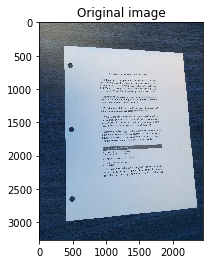

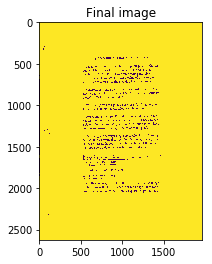

In [11]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
 
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
 
# show the original and scanned images
print("STEP 3: Apply perspective transform")

plt.imshow(orig) 
imutils.resize(orig, height = 650)
plt.title("Original image")
plt.show()

plt.imshow(warped) 
imutils.resize(orig, height = 650)
plt.title("Final image")
plt.show()

# show the original and scanned images
# print("STEP 3: Apply perspective transform")
# cv2.imshow("Original", imutils.resize(orig, height = 650))
# cv2.imshow("Scanned", imutils.resize(warped, height = 650))
# cv2.waitKey(0)
# cv2.destroyAllWindows()